In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans


from sklearn.metrics import classification_report
from wordcloud import WordCloud 
from gensim  import corpora, models

#from textblob import TextBlob


In [2]:
#pip install wordcloud


In [3]:
raw_data = pd.read_csv('abcnews-date-text2.csv', parse_dates=[0], infer_datetime_format=True)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499999 entries, 0 to 499998
Data columns (total 2 columns):
publish_date     499999 non-null datetime64[ns]
headline_text    499999 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 7.6+ MB


In [4]:
raw_data.describe()

,publish_date,headline_text
count,499999,499999
unique,2450,494815
top,2008-10-31 00:00:00,closer am1
freq,362,318
first,2003-02-19 00:00:00,NaN
last,2009-11-12 00:00:00,NaN


In [5]:
print(raw_data.headline_text.unique().size)
print(raw_data.publish_date.unique().size)
print(raw_data.size)

494815
2450
999998


In [6]:
raw_data.tail()

,publish_date,headline_text
499994,2009-11-12,student suspension bill too similar to debate
499995,2009-11-12,swift trumps urban at country music awards
499996,2009-11-12,symonds back for bulls
499997,2009-11-12,tamils reject deal to disembark
499998,2009-11-12,tank solution


In [7]:
print(list(raw_data))

['publish_date', 'headline_text']


In [8]:
raw_data.dtypes

publish_date     datetime64[ns]
headline_text            object
dtype: object

In [9]:
raw_data.shape


(499999, 2)

**Remove stopwords from the headlines

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
print(stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pasky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

1. Tokenization: the process of segmenting text into words, clauses or sentences (here we will separate out words and remove punctuation).
2. Stemming: reduces related words to a common stem.
3. Removal of stop words: removal of commonly used words unlikely to be useful for learning.
4. Vectorization is the process of converting an algorithm from operating on a single value at a time to operating on a set of values (vector) at one time

In [11]:
raw_data['headline_text'] = raw_data['headline_text'].str.lower()

In [12]:
eg_headline = raw_data.iloc[0]
print(eg_headline['headline_text'])
print(eg_headline['publish_date'])

aba decides against community broadcasting licence
2003-02-19 00:00:00


In [13]:
#Tokenization
nltk.download('punkt')

print(nltk.word_tokenize(eg_headline['headline_text']))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pasky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']


In [14]:
#apply word_tokenize to all records, make a new column. And remove alphanumeric words using .isalpha
def identify_tokens(row):
    headline_text = row['headline_text']
    tokens = nltk.word_tokenize(headline_text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words
raw_data['words'] = raw_data.apply(identify_tokens, axis = 1)


In [15]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pasky\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [16]:

#Remove stop words
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops]
    return(meaningful_words)
raw_data['removed_stop_words'] = raw_data.apply(remove_stops, axis =1)


In [17]:
#Rejoin words

def rejoin_words(row):
    my_list = row['removed_stop_words']
    joined_words = ( " ".join(my_list))
    return joined_words
raw_data['processed'] = raw_data.apply(rejoin_words, axis =1)


In [18]:
#Save processed data.(Drop some columns)
#raw_data.drop([['headline_text', 'words']],axis = 1, inplace = True)
raw_data.to_csv('raw_data_processed',index = True)


In [19]:
#Word count for each row
raw_data['word_count'] = raw_data['processed'].apply(lambda x:len(str(x).split(" ")))
raw_data[['processed', 'word_count']].sample(10)

,processed,word_count
77034,celtic keep double hopes alive,5
356599,alan bottomly snug bushfires,4
211808,states accused lagging counter terrorism,5
194149,joyce vote fallout overreaction,4
165411,canberra writes japanese sister city condemn,6
4710,mozzie coil may behind house blaze,6
441610,stinging caterpillars infest rural darwin,5
288895,door closed walker facing lions,5
498986,heartbreaking despicable obama,3
332571,mattel says sorry china toy recalls,6


In [20]:
raw_data.word_count.describe()

count    499999.000000
mean          5.140940
std           1.076944
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          11.000000
Name: word_count, dtype: float64

In [21]:
#identify common words
freq = pd.Series(''.join(raw_data['processed']).split()).value_counts()[:20]
freq

new        7986
govt       6730
says       6534
police     6168
urged      5393
water      5010
may        4786
us         4627
court      4529
back       4245
charged    4143
council    4049
killed     3978
man        3889
face       3683
fire       3604
set        3603
health     3500
calls      3367
plan       3155
dtype: int64

**Graph of most common words in the dataset excluding stop words


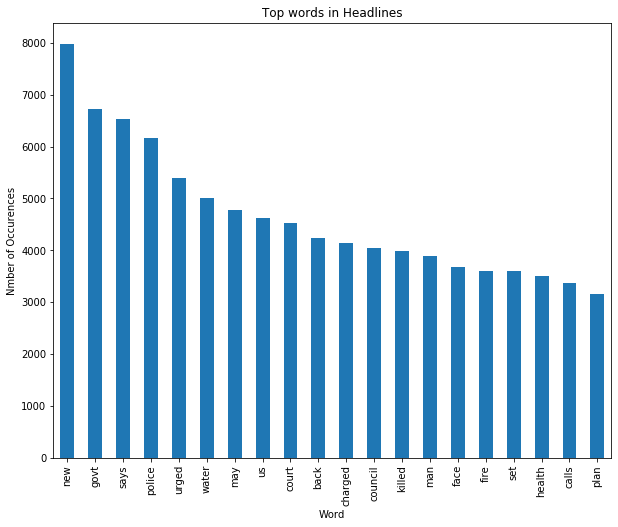

In [22]:
freq.plot(kind='bar', figsize =(10,8))
plt.title('Top words in Headlines' )
plt.xlabel('Word')
plt.ylabel('Nmber of Occurences')
plt.show()

**Building a word cloud to chevk most frequent words

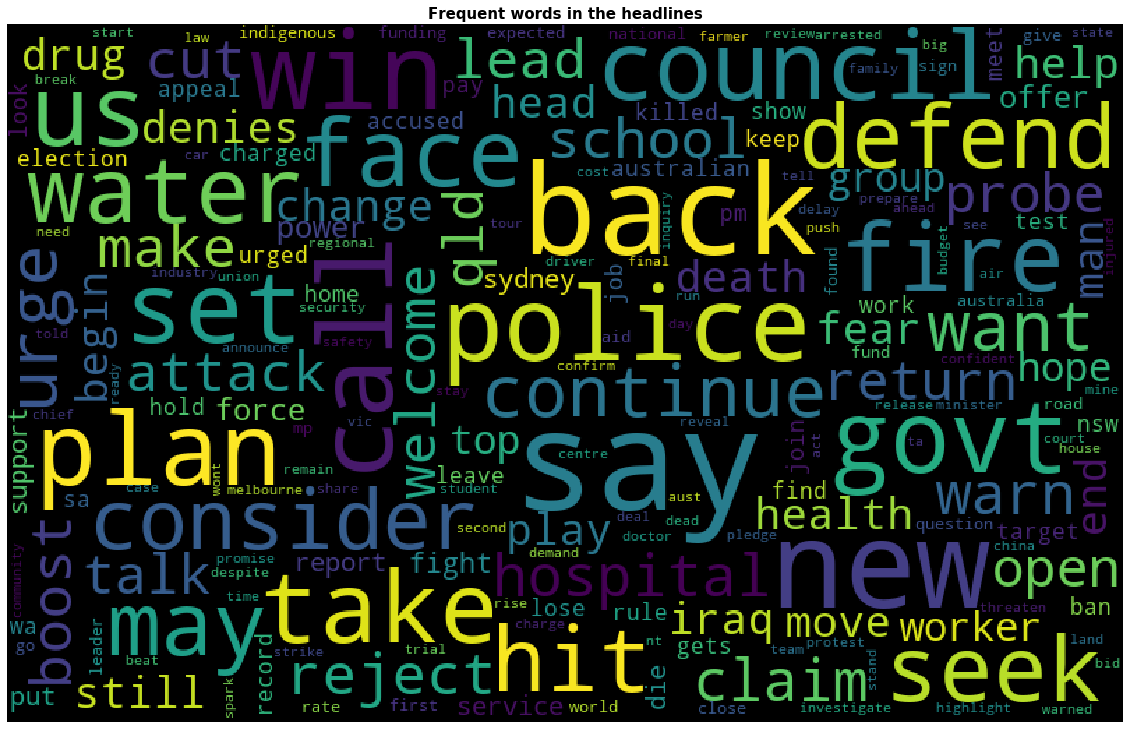

In [23]:
headline_words = ''.join([word for word in raw_data['processed'][0:499995]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 21).generate(headline_words)
plt.figure(figsize = (20,16))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Frequent words in the headlines', weight = 'bold',fontsize = 15)
plt.show()


In [24]:
raw_data.drop(['headline_text', 'words', 'removed_stop_words'], inplace = True, axis = 1) 
raw_data.sample(5)

,publish_date,processed,word_count
201193,2005-11-17,gonzalez hands puerta speedy exit,5
319661,2007-07-25,us housing market drags aust shares,6
402905,2008-08-10,chinese pair takes springboard gold,5
283786,2007-02-04,von einem charged selling cards,5
140523,2005-01-20,surf life saving competition begins today,6


Distribution of headdlines across months

In [25]:
raw_data['day'] = pd.DatetimeIndex(raw_data['publish_date']).day
raw_data['month'] = pd.DatetimeIndex(raw_data['publish_date']).month
raw_data['year'] = pd.DatetimeIndex(raw_data['publish_date']).year

raw_data.head(5)

,publish_date,processed,word_count,day,month,year
0,2003-02-19,aba decides community broadcasting licence,5,19,2,2003
1,2003-02-19,act fire witnesses must aware defamation,6,19,2,2003
2,2003-02-19,g calls infrastructure protection summit,5,19,2,2003
3,2003-02-19,air nz staff aust strike pay rise,7,19,2,2003
4,2003-02-19,big hopes launceston cycling championship,5,19,2,2003


Text(0.5, 1.0, 'Distribution of headlines across months')

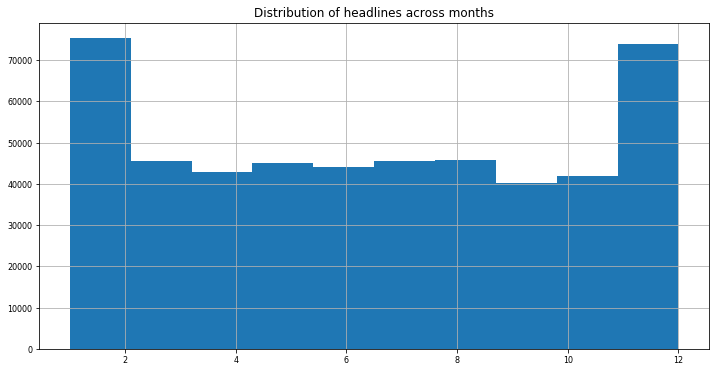

In [26]:
raw_data['month'].hist(figsize = (12,6), bins = 10, xlabelsize=8, ylabelsize=8)
plt.title('Distribution of headlines across months')

The start and end of the year have contributed to most headlines

Text(0.5, 1.0, 'Distribution of headlines across years')

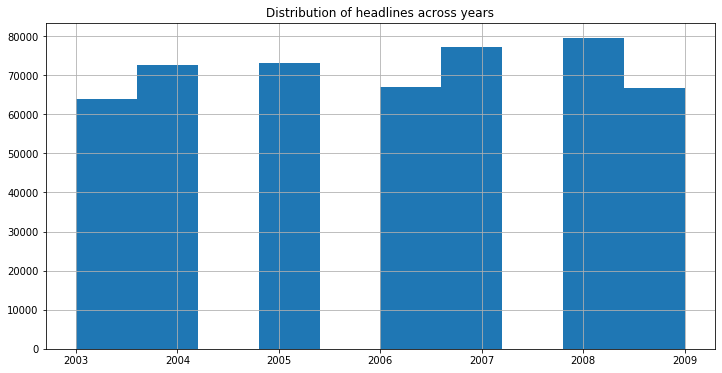

In [27]:
raw_data['year'].hist(figsize = (12,6), bins = 10, xlabelsize=10, ylabelsize=10)
plt.title('Distribution of headlines across years')

Create visualisation for each day for the whole dataset to try to know why their are differences in the nuber of headlines.

Set publish_date as index then resample the data

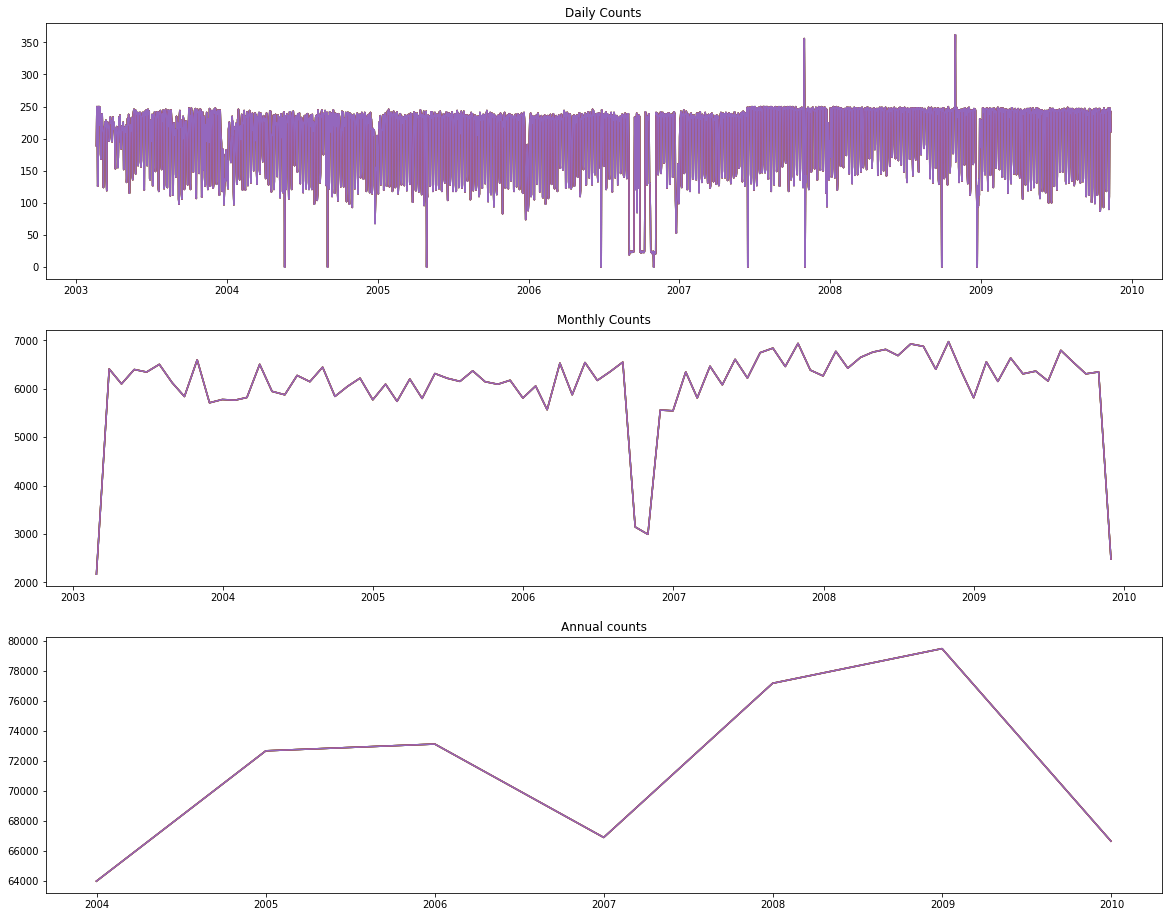

In [28]:
raw_data.set_index('publish_date', inplace = True)
#raw_data.sample(5)
day_cnt = raw_data.resample('D').count()
month_cnt = raw_data.resample('M').count()
year_cnt = raw_data.resample('Y').count()

fig, ax = plt.subplots(3, figsize=(20,16))
ax[0].plot(day_cnt)
ax[0].set_title('Daily Counts')
ax[1].plot(month_cnt)
ax[1].set_title('Monthly Counts')
ax[2].plot(year_cnt)
ax[2].set_title('Annual counts')
plt.show()

Pre-Processing. 

**Feature Construction** take samples of text headlines and represent them in some tractable feature space. Convert each string to numerical value. we use CountVectoriser.

In [29]:
small_cv = CountVectorizer(stop_words='english', max_features=40000, lowercase=False)
small_df_sample = raw_data['processed'].sample(n=10000, random_state=0).values
print('Headline before vectorization: {}'.format(small_df_sample[9999]))
small_dtm = small_cv.fit_transform(small_df_sample)
print('Headline after vectorization: \n{}'.format(small_dtm[9999]))

Headline before vectorization: community get look health issues study
Headline after vectorization: 
  (0, 4442)	1
  (0, 9289)	1
  (0, 5672)	1
  (0, 2022)	1
  (0, 5024)	1


In [30]:
tf_vect =TfidfVectorizer(stop_words=stops,max_features=1000)
news_vect_matrix = tf_vect.fit_transform(raw_data['processed'])

In [31]:
news_vect_matrix.shape

(499999, 1000)

In [32]:
#pip install -U gensim

**METHOD 1: 
**LATENT DIRICHLET ALLOCATION model** - topics generate words based on their probability distribution. LDA backtracks and tries to figure out what topics would create those documents in the first place. It uncovers hidden topic structures in a document.

**We can now see the most frequent and rare words in the news headlines based on idf score. 
**The lesser the value; more common is the word in the news headlines

In [34]:
#print(dt_matrix.shape)
#print(dt_matrix)

In [35]:
lda = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=0, max_iter=4)
lda_model_matrix = lda.fit_transform(small_dtm)

In [36]:
lda_model_matrix

array([[0.0125    , 0.0125    , 0.0125    , ..., 0.01250145, 0.88749855,
        0.0125    ],
       [0.01666667, 0.01666667, 0.85      , ..., 0.01666667, 0.01666667,
        0.01666667],
       [0.02      , 0.02      , 0.02000067, ..., 0.0200071 , 0.02000349,
        0.02      ],
       ...,
       [0.51666844, 0.01666667, 0.01666667, ..., 0.18333197, 0.01666667,
        0.01666714],
       [0.01666667, 0.01666667, 0.01666667, ..., 0.18341684, 0.01666667,
        0.01666667],
       [0.18333278, 0.01666667, 0.01666667, ..., 0.51666663, 0.18333298,
        0.01666667]])

In [37]:
#values in each row add up to 1. Each value showss the percentage contribution of the corresponding topic in the doc
sum  = 0
for i in lda_model_matrix[9990]:
    sum=sum+i
print(sum)

1.0


In [38]:
#Composition of each document in the corpus
print('Document 0: ' )
for i, topic in enumerate(lda_model_matrix[0]):
    print('Topic',i,':', topic*100, '%')

    
#topic 4 in document 0 is dominant

Document 0: 
Topic 0 : 1.2500000128544877 %
Topic 1 : 1.2500000128101105 %
Topic 2 : 1.2500000137743859 %
Topic 3 : 1.2500000104885929 %
Topic 4 : 1.2500000133608475 %
Topic 5 : 1.2500000125158943 %
Topic 6 : 1.2500000126853044 %
Topic 7 : 1.2501452924465943 %
Topic 8 : 88.7498546050299 %
Topic 9 : 1.2500000140338832 %


Topic categories are characterised by the most frequent words

In [39]:
words = tf_vect.get_feature_names()

for i, comp in enumerate(lda.components_):
    vocab_comp = zip(words, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
broncos economic another govts face probe season coal hold disease 

Topic 1: 
pipeline hawks victoria suicide records play survey planned fishing plane 

Topic 2: 
bendigo crackdown address nz expected bangladesh industry holds make case 

Topic 3: 
perth warns aust launches concerns treatment rural row denies ban 

Topic 4: 
nsw law timor lawyer rock reports breaks mackay telstra debate 

Topic 5: 
philippines plan mental qantas close killing nationals welcomes deadline weekend 

Topic 6: 
bid custody returns times charge aussie cancer airport prompts may 

Topic 7: 
bad water scheme clear girl nt property lose toll prison 

Topic 8: 
crashes petrol worries liberals lanka growers driving lead teens damage 

Topic 9: 
rates honour rural death teens tax system double nrl art 



In [40]:
# Generate a word cloud image for given topic

def draw_word_cloud(index):
  imp_words_topic=""
  comp = lda.components_[index]
  vocab_comp = zip(words, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

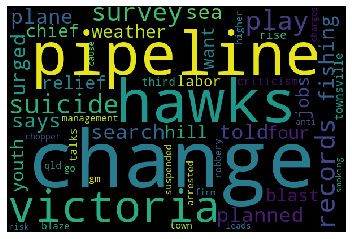

In [41]:
draw_word_cloud(1)

Method 3: K-Means Clustering

Elbow Method
Training multiple models using a different number  of clusters

WCSS- Within Cluster Sum of Squares

No.of clusters = x-axis value on the elbow point

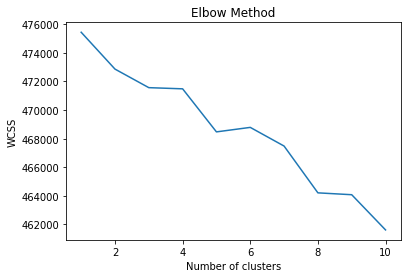

In [42]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1, n_init=10, random_state=0)
    kmeans.fit(news_vect_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [43]:
print(words[250:300])

['dispute', 'doctor', 'doctors', 'dog', 'dogs', 'dollar', 'double', 'doubt', 'downer', 'draw', 'drink', 'drive', 'driver', 'drivers', 'driving', 'drop', 'drought', 'drug', 'drugs', 'dump', 'eagles', 'early', 'ease', 'east', 'economic', 'economy', 'education', 'efforts', 'election', 'emergency', 'emissions', 'end', 'ends', 'energy', 'england', 'escape', 'eu', 'evidence', 'ex', 'expansion', 'expected', 'expert', 'export', 'extended', 'extra', 'face', 'faces', 'facing', 'fails', 'fall']


3 Clusters

In [44]:
kmeans = KMeans(n_clusters = 3, init='k-means++', n_init=10,n_jobs=1 )
pred_y = kmeans.fit(news_vect_matrix)
freq_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for num, centroid in enumerate(freq_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


0 : govt, new, us, council, says, plan, water, fire, court, qld, urged, back, iraq, report, health, may, nsw, hospital, call, pm, death, win, crash, claims, calls
1 : man, charged, court, jailed, police, murder, dies, missing, stabbing, car, accused, arrested, crash, guilty, face, assault, killed, attack, sex, charges, child, faces, death, search, accident
2 : police, investigate, probe, hunt, search, death, missing, seek, car, crash, fatal, drug, arrest, shooting, murder, officer, station, find, assault, road, drivers, body, new, say, help


5 clusters

In [45]:
kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=10,n_jobs=1 )
pred_y = kmeans.fit(news_vect_matrix)
freq_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for num, centroid in enumerate(freq_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


0 : us, council, water, fire, back, iraq, qld, report, crash, win, may, health, call, death, killed, urged, interview, claims, pm, calls, australia, hospital, sydney, set, talks
1 : govt, says, plan, urged, council, water, nsw, qld, sa, vic, opposition, wa, fed, group, rejects, health, nt, local, defends, funds, act, funding, fire, labor, mp
2 : new, laws, council, police, govt, chief, centre, year, hospital, home, deal, plan, president, mayor, gets, opens, get, years, pm, rules, may, water, qld, us, set
3 : police, investigate, probe, man, missing, hunt, search, death, seek, car, crash, arrest, fatal, drug, shooting, murder, officer, find, assault, station, road, body, help, say, drivers
4 : man, court, charged, face, murder, accused, jailed, faces, dies, told, charges, stabbing, crash, car, sex, guilty, hears, assault, arrested, child, death, front, missing, attack, killed


8 clusters

In [47]:
kmeans = KMeans(n_clusters = 8, init='k-means++', n_init=10,n_jobs=1 )
pred_y = kmeans.fit(news_vect_matrix)
freq_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

for num, centroid in enumerate(freq_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


0 : new, council, water, plan, restrictions, laws, considers, mayor, centre, seeks, plans, says, may, land, backs, urged, get, development, boost, rejects, gets, residents, qld, use, rise
1 : police, investigate, probe, hunt, search, death, missing, seek, car, crash, fatal, drug, arrest, murder, shooting, officer, find, station, assault, road, drivers, body, say, new, help
2 : govt, urged, nsw, qld, vic, fed, sa, says, wa, local, plan, act, defends, nt, funds, funding, accused, water, fire, rejects, new, considers, federal, tas, opposition
3 : man, charged, court, jailed, police, murder, dies, missing, stabbing, car, accused, arrested, crash, guilty, face, assault, killed, attack, sex, charges, child, faces, death, search, accident
4 : iraq, us, troops, war, killed, bush, soldiers, un, kills, says, pm, bomb, attacks, howard, report, attack, kill, soldier, suicide, violence, british, aust, wheat, new, dead
5 : pm, home, closer, new, return, says, thai, first, former, defends, solomons, 